# Regression on FAA flight delay data

* Linear regression
* XGBoost regression

In [1]:
import os
import warnings
import json
import copy
import numpy as np
import pandas as pd
import pandas_profiling
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
df = pd.read_csv('./data/faa_full.csv')
with pd.option_context('display.max_rows', 5, 'display.max_columns', 300):
    display(df)

,MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,ARR_DELAY,DISTANCE,CRS_ELAPSED_TIME,CRS_DEP_HOUR,CRS_ARR_HOUR,DEP_DELAY
0,3,4,AA,DFW,PSP,-8.0,1126.0,187.0,11,12,-8.0
1,3,5,AA,DFW,PSP,12.0,1126.0,187.0,11,12,22.0
...,...,...,...,...,...,...,...,...,...,...,...
5573745,6,5,WN,BWI,MKE,19.0,641.0,120.0,14,15,27.0
5573746,6,5,WN,BWI,MSP,-15.0,936.0,170.0,8,10,-4.0


In [3]:
# Create categorical columns
df['UNIQUE_CARRIER'] = df['UNIQUE_CARRIER'].astype('category')
df['ORIGIN'] = df['ORIGIN'].astype('category')
df['DEST'] = df['DEST'].astype('category')
carrier_cat = df['UNIQUE_CARRIER'].cat.categories.values
print('UNIQUE_CARRIER categories: ', carrier_cat)
origin_cat = df['ORIGIN'].cat.categories.values
print('ORIGIN categories: ', len(origin_cat))
dest_cat = df['DEST'].cat.categories.values
print('DEST categories: ', len(dest_cat))

UNIQUE_CARRIER categories:  ['AA' 'AS' 'B6' 'DL' 'EV' 'F9' 'HA' 'NK' 'OO' 'UA' 'VX' 'WN']
ORIGIN categories:  315
DEST categories:  316


In [4]:
# Convert categories into integers
cat_columns = df.select_dtypes(['category']).columns
print('Categorical columns: ', cat_columns.values)
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
print('Columns:')
print(df.dtypes)

with pd.option_context('display.max_rows', 5, 'display.max_columns', 300):
    display(df)

Categorical columns:  ['UNIQUE_CARRIER' 'ORIGIN' 'DEST']
Columns:
MONTH                 int64
DAY_OF_WEEK           int64
UNIQUE_CARRIER         int8
ORIGIN                int16
DEST                  int16
ARR_DELAY           float64
DISTANCE            float64
CRS_ELAPSED_TIME    float64
CRS_DEP_HOUR          int64
CRS_ARR_HOUR          int64
DEP_DELAY           float64
dtype: object


,MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,ARR_DELAY,DISTANCE,CRS_ELAPSED_TIME,CRS_DEP_HOUR,CRS_ARR_HOUR,DEP_DELAY
0,3,4,0,82,247,-8.0,1126.0,187.0,11,12,-8.0
1,3,5,0,82,247,12.0,1126.0,187.0,11,12,22.0
...,...,...,...,...,...,...,...,...,...,...,...
5573745,6,5,11,51,200,19.0,641.0,120.0,14,15,27.0
5573746,6,5,11,51,212,-15.0,936.0,170.0,8,10,-4.0


In [5]:
target = 'ARR_DELAY'
cat_feat_names = ['UNIQUE_CARRIER', 'ORIGIN', 'DEST']
num_feat_names = ['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_HOUR', 'CRS_ARR_HOUR', 'DISTANCE',
                  'CRS_ELAPSED_TIME', 'DEP_DELAY']
features = cat_feat_names + num_feat_names
    
cat_feat_indxs = [0, 1, 2]

x = df[features].values
y = df[target].values
print('x: ', x.shape, 'y: ', y.shape)

x:  (5573747, 10) y:  (5573747,)


In [6]:
enc = OneHotEncoder(categorical_features=cat_feat_indxs, sparse=True)
x_onehot = enc.fit_transform(x)
print('x_onehot: ', type(x_onehot), x_onehot.shape)
print('Number of categories: ', enc.n_values_)
print('Indices of categorical features: ', enc.feature_indices_)

x_onehot:  <class 'scipy.sparse.coo.coo_matrix'> (5573747, 650)
Number of categories:  [ 12 315 316]
Indices of categorical features:  [  0  12 327 643]


In [7]:
# Create list of feature names
feat_cats = [carrier_cat, origin_cat, dest_cat]
to_zip = [cat_feat_names, feat_cats, enc.n_values_]
assert len(cat_feat_names) == len(feat_cats) == len(enc.n_values_) == len(enc.feature_indices_)-1 == 3
all_cat_feat_names = []
for i, (feat_name, cat_names, n_vals) in enumerate(zip(*to_zip)):
    start = enc.feature_indices_[i]
    end = enc.feature_indices_[i+1]
    assert len(cat_names) == n_vals == (end-start)
    all_cat_feat_names += [feat_name+'_'+cat_name  for cat_name in cat_names]
all_cat_feat_names += num_feat_names
assert len(all_cat_feat_names) == x_onehot.shape[1]
print('all_cat_feat_names: ', len(all_cat_feat_names))

all_cat_feat_names:  650


In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x_onehot, y, test_size=0.2, random_state=42)

print('x_train: ', type(x_train), x_train.shape)
print('y_train: ', type(y_train), y_train.shape)
print('x_test: ', type(x_test), x_test.shape)
print('y_test: ', type(y_test), y_test.shape)

x_train:  <class 'scipy.sparse.csr.csr_matrix'> (4458997, 650)
y_train:  <class 'numpy.ndarray'> (4458997,)
x_test:  <class 'scipy.sparse.csr.csr_matrix'> (1114750, 650)
y_test:  <class 'numpy.ndarray'> (1114750,)


## Simple Linear Regression

In [9]:
# Train the model using the training sets
linreg_model = linear_model.LinearRegression(n_jobs=4)
linreg_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

y_train_pred:  (4458997,)
Mean absolute error: 8.853711516627895
Variance score: 0.9232505479951323


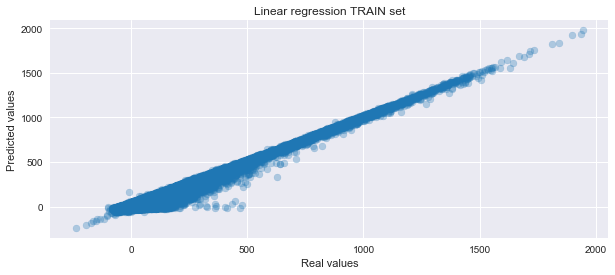

In [10]:
# Predictions from train set
y_train_pred = linreg_model.predict(x_train)
print('y_train_pred: ', y_train_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Variance score: {}'.format(r2_score(y_train, y_train_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_train, y_train_pred, alpha=.3)
plt.title('Linear regression TRAIN set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

y_test_pred:  (1114750,)
Mean absolute error: 8.834914761737785
Variance score: 0.9231952454810273


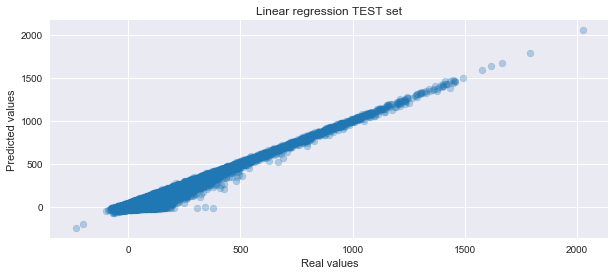

In [11]:
# Predictions from test set
y_test_pred = linreg_model.predict(x_test)
print('y_test_pred: ', y_test_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_test, y_test_pred)))
print('Variance score: {}'.format(r2_score(y_test, y_test_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_test, y_test_pred, alpha=.3)
plt.title('Linear regression TEST set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

## XGBoost regression

In [12]:
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=all_cat_feat_names)
dtest = xgb.DMatrix(x_test, label=y_test, feature_names=all_cat_feat_names)

In [13]:
# XGBoost parameters explained: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
params = {
    # Parameters to tune
    'max_depth': 3,  # Maximum depth of a tree
    'min_child_weight': 3,  # Minimum number of instances needed to be in each node
    'eta': .1,  # Learning_rate (shrinks the feature weights to make the boosting process more conservative)
    'subsample': 1,  # Subsample ratio of the training instance
    'colsample_bytree': 1,  # Subsample ratio of columns
    'lambda': 0,  # L2 regularization term
    'alpha': 0,  # L1 regularization term
    'gamma': 1,  # Minimum loss reduction required to make a further partition
    # Other params
    'objective': 'reg:linear',
    'eval_metric': 'rmse'
}

boost_rounds = 100

# Train final model
xgb_model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=boost_rounds
)

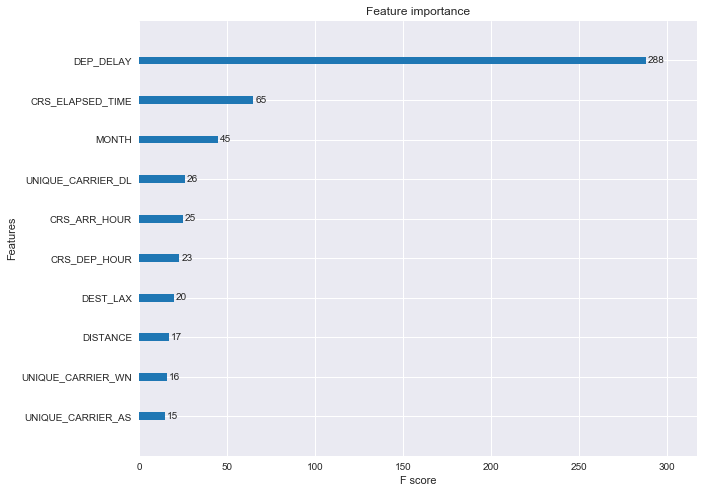

In [14]:
# Show feature importances
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
xgb.plot_importance(xgb_model, ax=ax, max_num_features=10)
plt.show()

y_train_pred:  (4458997,)
Mean absolute error: 10.269072707164527
Variance score: 0.744162335397207


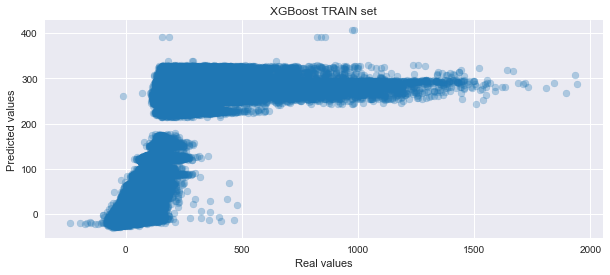

In [15]:
# Predictions from train set
y_train_pred = xgb_model.predict(dtrain)
print('y_train_pred: ', y_train_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Variance score: {}'.format(r2_score(y_train, y_train_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_train, y_train_pred, alpha=.3)
plt.title('XGBoost TRAIN set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

y_test_pred:  (1114750,)
Mean absolute error: 10.236911488128554
Variance score: 0.7460173407394629


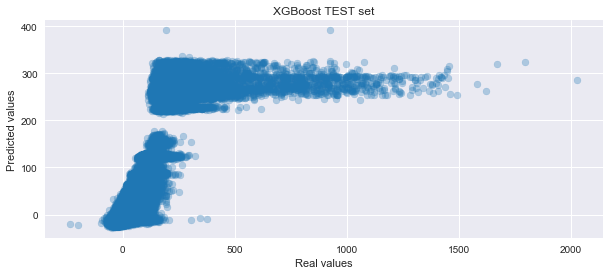

In [16]:
# Predictions from test set
y_test_pred = xgb_model.predict(dtest)
print('y_test_pred: ', y_test_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_test, y_test_pred)))
print('Variance score: {}'.format(r2_score(y_test, y_test_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_test, y_test_pred, alpha=.3)
plt.title('XGBoost TEST set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()